# Extract bid/ask rate from messages

In [9]:
import os
import re
import pytz
import pathlib
import numpy as np
import pandas as pd
from datetime import datetime
from utils import append_df_to_excel

In [10]:
# current date & time
NOW = datetime.strftime(datetime.now().astimezone(tz=pytz.timezone('Europe/Moscow')), format='%Y%m%d_%H%M%S')

In [11]:
# paths
PATH_SRC = pathlib.Path()
PATH_DATA = pathlib.Path() / '../data'
PATH_DATA_TG = PATH_DATA / 'telegram'
PATH_REPORTS = pathlib.Path() / '../reports'

In [12]:
# INPUT CHAT
chat = 'obmenvmsk' #'obmenvmsk'
PATH_CHAT = PATH_DATA_TG / chat 

In [13]:
# data load
# TODO: SQL from CH
df_all = pd.DataFrame()
for csv in os.listdir(PATH_CHAT):
    df_all = df_all.append(pd.read_csv(PATH_CHAT / csv))# Data_load.ipynb

In [14]:
# do some wrangling

df = df_all.loc[df_all['source']==chat]
df = df.replace(np.nan, '', regex=True)
df['dt'] = df['dt'].astype('datetime64[ns]')
df = df.sort_values(by='message_id')
df.text = df.text.str.lower()
print(df.dt.max())

2022-04-18 16:42:29


In [15]:
# Patterns

# exclude 
exclude = '((?<!можно)(?<!купюрами)(?<!купюры)(?<!купуюры)(?<!номинал))'

# bid/ask
pattern_type = '(п(р|)ода(жа|ю|м|дим)|отда(м|ю|дим)|мен|куп(им|ить|лю)|кто(.*?)прод|(взят|возьм))'

# currency 
pattern_usd = '(дол(л|.|лар(|ы|ов))|usd|doll(|ar)|\$|🇺🇸|💵|💲|💰|🤑|💸)'
pattern_eur = '(евр|e(u|v)r|€|💶|🇪🇺)'
# parse usd 
pattern_curr = pattern_usd

# value patterns
# по 80 р, по 80 доллар, exclude when value is followed by ')' or 'коп'
a0 = f'({exclude}(^$|\s)(по)[\s,\-=:](| |  )\d+(| |  )(?!(.*)(\)|коп))($|р|₽|(.*){pattern_curr}))' 
# $-80, доллар 80 (must have . or , after rate) OR доллар по 80 р take only when text is not followed by "курс"/"по"
a1 = f'({pattern_curr}(|\s)([\s=:\-](|\s)\d+[.,]\s|(|\s)(\D)(по|)(|[\-=:])(| |  )(|~)\d+(| |  )(р|₽)))(?!((.*)курс)|(.*)по)' 
# курс 80, exclude "1 к 1", or if followed by another int
a2 = '((курс(|у)|цен(а|е)|стоимост(|и))(|[\-=:])(| |  )\d+(?!((|\s)(к|:)(|\s)1)|((.*)\d+)))' 
# $1000 по 80 (or 1000$ по 80), exclude volume in the beginning, take only when not followed by ("за шт", "за $", "к 1")
a3 = f'((?!({pattern_curr}(.*)\d+(.*)))\s(курс(|у)|цен(а|е)|стоимост(|и)|по|не дороже)(|[,\-=:])\s\d+(?!(.*)(за (шт|[а-я+]))|((.*){pattern_curr}|((|\s)(к|:)(|\s)1))))' 
# 80 р за доллар (may or may not have "по")
a4 = f'({exclude}\d+(|\s)(р|₽)(.*)([\-=:])(|\s)(|1)(|\s){pattern_curr})' 

# join value patterns, convert to str
a_list = [a0,a1,a2,a3,a4]
pattern_value = '|'.join(a_list)

In [16]:
# get structured data
df_ = df.copy()
texts = list(df_.text)
dates = list(df_.dt)

patterns = [
            fr'{pattern_type}',
            fr'{pattern_curr}',
            pattern_value
            ]

usd_extract = []
for i,text in enumerate(texts):
    
    # element: dt and message
    el = [dates[i],text]

    # pattern match for each pattern in patterns
    match_list = [re.search(patt, text) for patt in patterns]
    for el_match in match_list:
        # extract matching group and append to element
        el_match_gr = (el_match.group() if el_match is not None else None)
        el.append(el_match_gr)
    
    # get rate from matched pattern
    el_match_num = re.search(r'(\d+)', el[-1]).group() if el[-1] is not None else None
    el.append(el_match_num)

    # parse all ints into list and append to element
    num_list = [float(e) for e in re.findall(r'(\d+)',text)]
    el.append(num_list if len(num_list)>0 else -1) # if no ints, return -1

    # append _element_ to list of lists
    usd_extract.append(el)

# transform list of lists to DataFrame
df_usd_extract = pd.DataFrame(usd_extract)
df_usd_extract.columns = ['dt','text','trans_type', 'currency','value_string','rate', 'value_list']
df_usd_extract = df_usd_extract[df_usd_extract['value_list']!=-1]

In [17]:
df_usd_extract_ = df_usd_extract[~df_usd_extract.rate.isna()]
df_usd_extract_.shape

(7522, 7)

In [18]:
# df_sample = df_usd_extract[~df_usd_extract.currency.isna()&df_usd_extract.rate.isna()].sample(10).copy()
# df_sample.iloc[:,1:]

In [19]:
# get clean table

df_usd_extract['value_list'] = df_usd_extract['value_list'].apply(
    lambda x: list(filter(lambda i: (i <200)& (i>50) ,x)) ) # this is legacy, we don't use it in "production"
df_usd_extract['rate_list'] = df_usd_extract['value_list'].apply(lambda x: min(x) if len(x)>0 else None)

df_usd_extract['rate'] = df_usd_extract['rate'].astype('float')

df_usd = df_usd_extract[(~df_usd_extract['rate'].isna())&(~df_usd_extract['currency'].isna())].copy()


In [20]:
# some heuristics to filter outliers
MIN_RATE = 10 
df_usd = df_usd[df_usd['rate']>=MIN_RATE]
MAX_RATE = 1000 # actually will do without this filter
df_usd = df_usd[df_usd['rate']<=MAX_RATE]

In [21]:
# decode trans type (bid/ask)
df_usd['trans_type'] = df_usd['trans_type'].fillna('продаю')
ask_series = df_usd['trans_type'].apply(lambda x: re.sub(r'(п(р|)ода(жа|ю|м|дим)|отда(м|ю|дим)|мен)', "ask", x))
df_usd['type'] = ask_series.apply(lambda x: re.sub(r'(куп(им|ить|лю)|кто(.*?)прод|(взят|возьм))', "bid", x))

<AxesSubplot:xlabel='dt'>

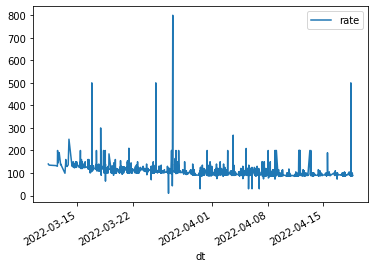

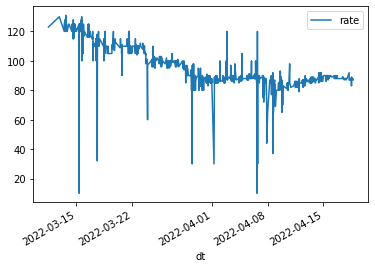

In [22]:
df_usd[df_usd['type']=='ask'][['dt','rate']].set_index('dt').plot()
df_usd[df_usd['type']=='bid'][['dt','rate']].set_index('dt').plot()

<AxesSubplot:xlabel='dt'>

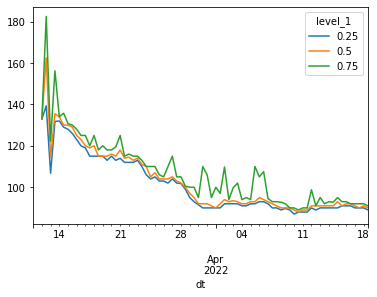

In [23]:
df_usd_v = df_usd[df_usd['type']=='ask'][['dt','rate']].copy()
df_usd_v_q = df_usd_v.set_index('dt')\
        .resample('12h').quantile(q=[.25,.5,.75]).reset_index()
df_usd_v_q.pivot(index='dt',values='rate',columns='level_1').plot()

<AxesSubplot:xlabel='dt'>

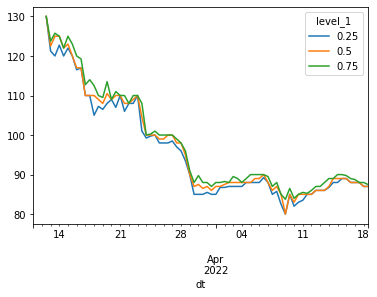

In [24]:
df_usd_v = df_usd[df_usd['type']=='bid'][['dt','rate']].copy()
df_usd_v_q = df_usd_v.set_index('dt')\
        .resample('12h').quantile(q=[.25,.5,.75]).reset_index()
df_usd_v_q.pivot(index='dt',values='rate',columns='level_1').plot()

In [25]:
# save
filename = f'fxcash_usd_{NOW}_{chat}.xlsx'
df_usd.to_excel(PATH_REPORTS / filename, sheet_name='clean')

# save raw data to a separate sheet
append_df_to_excel(PATH_REPORTS / filename, df_usd_extract, sheet_name='raw')

In [26]:
# calculate price quantiles
quantiles = [0.1,0.25,0.5,0.75,0.9]
types = ['ask','bid']

df_quantiles = pd.DataFrame()
for t in types:
        df_usd_ask = df_usd[df_usd['type']==t][['dt','rate']].copy()
        df_usd_ask_q = df_usd_ask.set_index('dt')\
                .resample('1d').quantile(q=quantiles).reset_index()\
                .pivot(index='dt',values='rate',columns='level_1')

        df_usd_ask_q.columns = quantiles
        df_usd_ask_q.columns = [f'q={x}_{t}' for x in quantiles]
        df_quantiles = pd.concat([df_quantiles,df_usd_ask_q],axis=1)

# append quantiles to new sheet
append_df_to_excel(PATH_REPORTS / filename, df_quantiles, sheet_name='quantiles')

In [28]:
# FINAL FILE
print(PATH_REPORTS.absolute() / filename)

/home/ubuntu/fxcash/src/../reports/fxcash_usd_20220418_164635_obmenvmsk.xlsx
